<a href="https://colab.research.google.com/github/omdgit/AppliedTimeSeriesAnalysisWithPython/blob/main/my work/HOTSAP_SARIMAX.ipynb " target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Deep Learning in Time Series Analysis 

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../My-Code/')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import timetools as tt

%matplotlib inline

2023-01-22 20:18:27.683441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
plt.style.use('seaborn')

In [4]:
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [5]:
print(tf.__version__)

2.11.0


In [6]:
tf.random.set_seed(51)
np.random.seed(51)

## Appliance Energy Dataset 

In [9]:
df = pd.read_csv('../data/energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [10]:
df = df[::6]
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,47.233763,47.233763
12,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,34.351142,34.351142
18,2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,19.001759,19.001759
24,2016-01-11 21:00:00,110,30,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,13.361033,13.361033


In [11]:
df.shape

(3290, 29)

In [12]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

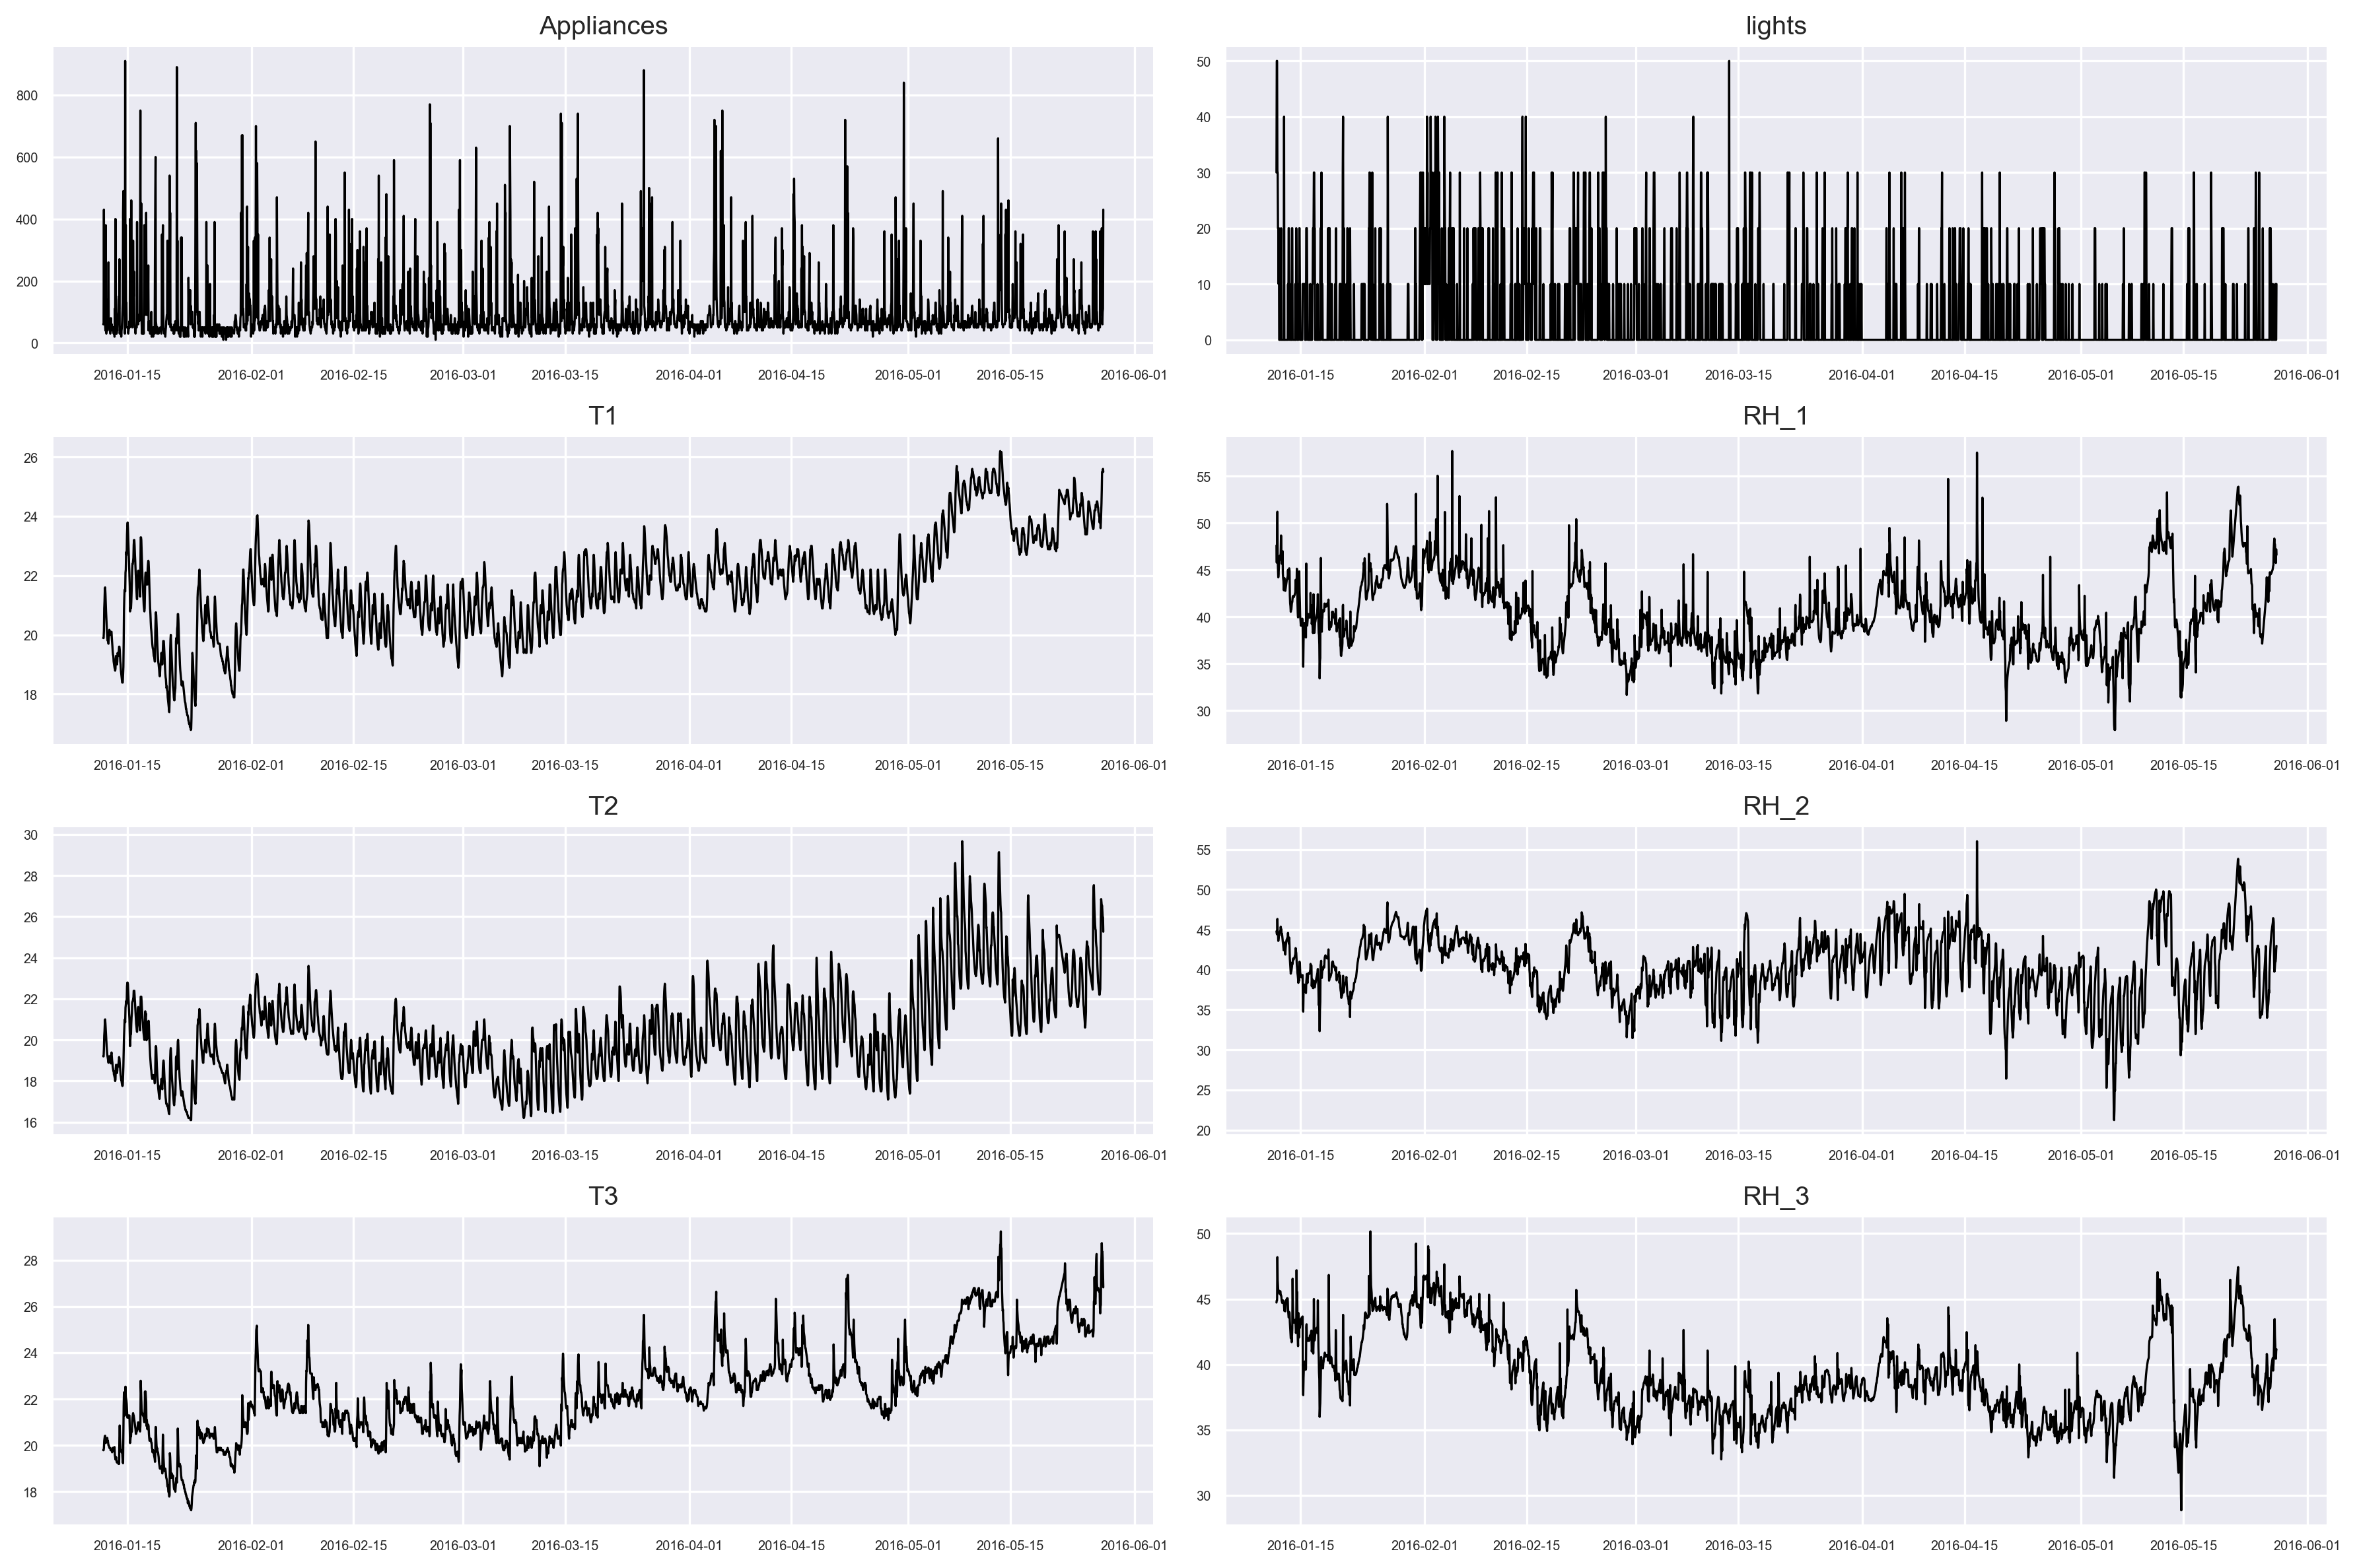

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=240, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color='black', linewidth=1)
    
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

## EDA (Exploratory Data Analysis) 

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333


In [16]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)

In [17]:
df.shape

(3290, 25)

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333
T5,3290.0,19.593729,1.846567,15.335000,18.290000,19.390000,20.613492,25.466667


## Feature Engineering 

### Time 

In [19]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-22 20:21:39.357589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 20:21:39.359753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-22 20:21:39.360111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


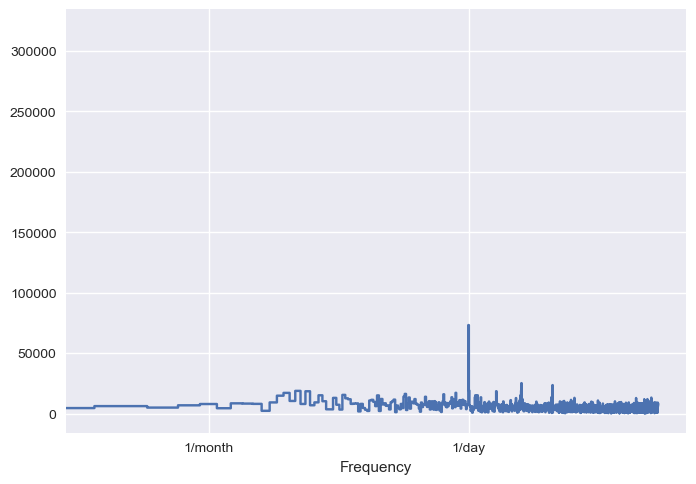

In [20]:
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h/hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/month', '1/day'])
plt.xlabel('Frequency')
plt.show()

In [21]:
day = 24 * 60 * 60

df['Day sin'] = (np.sin(timestamp_s * (2 * np.pi / day))).values
df['Day cos'] = (np.cos(timestamp_s * (2 * np.pi / day))).values

In [23]:
df.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Day sin,Day cos
0,60,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,-5.000000e-01,0.866025
6,60,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,-2.588190e-01,0.965926
12,430,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,-1.233163e-11,1.000000
18,80,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,2.588190e-01,0.965926
24,110,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,5.000000e-01,0.866025


### Split data 

In [24]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

There are 27 features


### Normalize data 

In [25]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

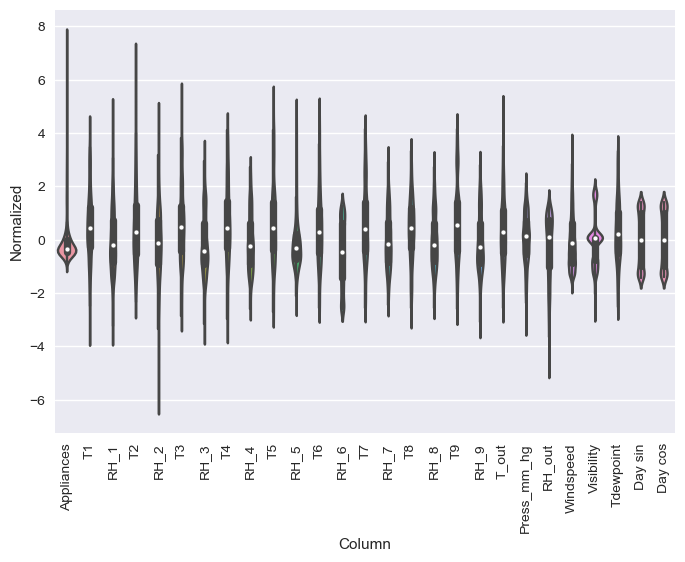

In [26]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing 

In [35]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [59]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, 
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(), 
                  optimizer=Adam(), 
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Single Step Models 

In [47]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Appliances'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

### Baseline 

In [48]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [49]:
baseline = Baseline(label_index=column_indices['Appliances'])

baseline.compile(loss=MeanSquaredError(),
                metrics=[MeanAbsoluteError()])

In [50]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 748us/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [51]:
wide_window = WindowGenerator(input_width=24,
                             label_width=24,
                             shift=1,
                             label_columns=['Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

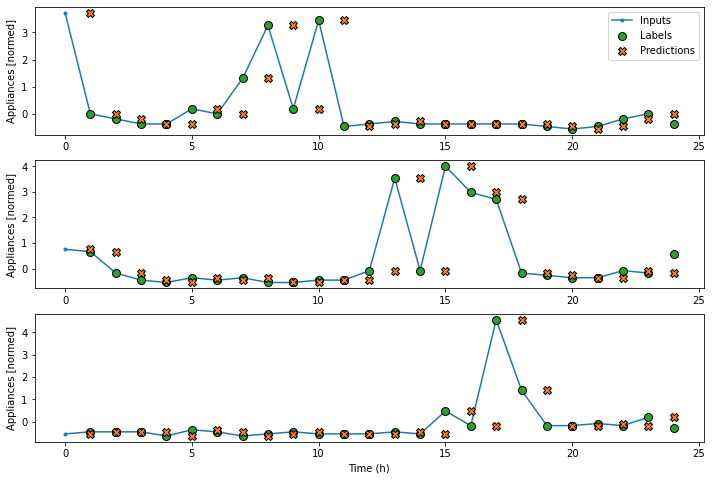

In [52]:
wide_window.plot(baseline)

### Linear model 

In [53]:
linear = Sequential([
    Dense(units=1)
])

In [60]:
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8212 - mean_absolute_error: 0.5024 - val_loss: 0.5371 - val_mean_absolute_error: 0.3965
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8193 - mean_absolute_error: 0.5008 - val_loss: 0.5388 - val_mean_absolute_error: 0.3918
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8187 - mean_absolute_error: 0.5012 - val_loss: 0.5380 - val_mean_absolute_error: 0.3894
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 0.8194 - mean_absolute_error: 0.5019 - val_loss: 0.5365 - val_mean_absolute_error: 0.4011
Epoch 5/50
72/72 [==============================] - 0s 1ms/step - loss: 0.8195 - mean_absolute_error: 0.5007 - val_loss: 0.5362 - val_mean_absolute_error: 0.3930
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8182 - mean_absolute_error: 0.5003 - val_loss: 0.5384 - val_mean_absolute_error: 0.3886
Epoch 7/50
72/72 [==========

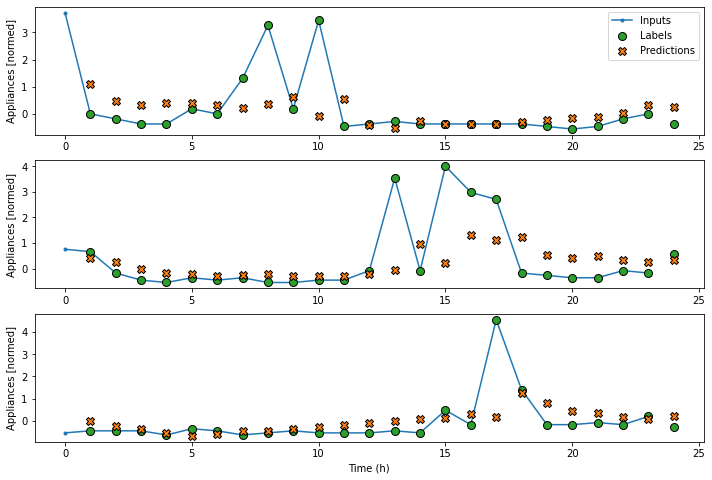

In [61]:
wide_window.plot(linear)

### Dense 

In [62]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 3ms/step - loss: 0.9075 - mean_absolute_error: 0.5499 - val_loss: 0.5500 - val_mean_absolute_error: 0.4093
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8076 - mean_absolute_error: 0.5058 - val_loss: 0.5569 - val_mean_absolute_error: 0.4067
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7757 - mean_absolute_error: 0.4947 - val_loss: 0.5817 - val_mean_absolute_error: 0.4288
Epoch 4/50
21/21 [==============================] - 0s 762us/step - loss: 0.5855 - mean_absolute_error: 0.4685


### CNN 

In [63]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Appliances']
)

In [64]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Appliances'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Appliances']

In [65]:
cnn_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 4ms/step - loss: 0.9239 - mean_absolute_error: 0.5606 - val_loss: 0.5779 - val_mean_absolute_error: 0.4618
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8057 - mean_absolute_error: 0.5169 - val_loss: 0.5468 - val_mean_absolute_error: 0.4283
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7682 - mean_absolute_error: 0.4957 - val_loss: 0.5378 - val_mean_absolute_error: 0.4058
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7421 - mean_absolute_error: 0.4903 - val_loss: 0.5266 - val_mean_absolute_error: 0.3858
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7200 - mean_absolute_error: 0.4755 - val_loss: 0.5640 - val_mean_absolute_error: 0.4117
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7012 - mean_absolute_error: 0.4675 - val_loss: 0.5296 - val_mean_absolute_error: 0.3902
Epoch 7/50
21/21 [==========

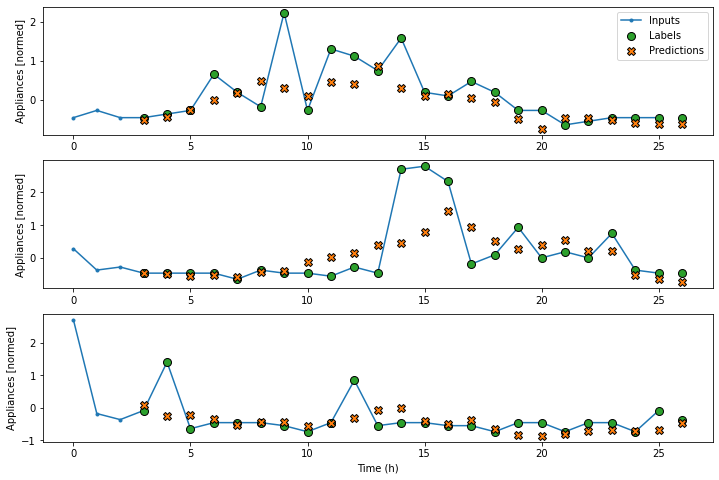

In [66]:
wide_conv_window.plot(cnn_model)

### LSTM 

In [67]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8875 - mean_absolute_error: 0.5340 - val_loss: 0.5743 - val_mean_absolute_error: 0.4121
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 0.7609 - mean_absolute_error: 0.4870 - val_loss: 0.6003 - val_mean_absolute_error: 0.4186
Epoch 3/50
72/72 [==============================] - 0s 5ms/step - loss: 0.7020 - mean_absolute_error: 0.4679 - val_loss: 0.6145 - val_mean_absolute_error: 0.4411
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6042 - mean_absolute_error: 0.4401


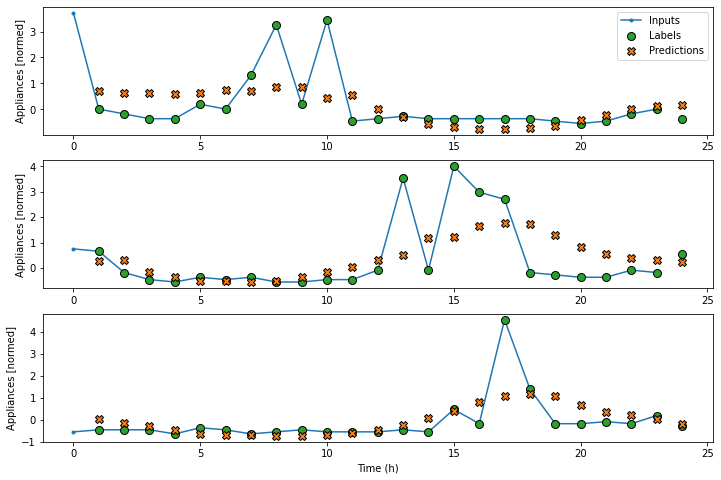

In [68]:
wide_window.plot(lstm_model)

In [69]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.9642 - mean_absolute_error: 0.5648 - val_loss: 0.5791 - val_mean_absolute_error: 0.4383
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8268 - mean_absolute_error: 0.5034 - val_loss: 0.5767 - val_mean_absolute_error: 0.4122
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7759 - mean_absolute_error: 0.4822 - val_loss: 0.5361 - val_mean_absolute_error: 0.3446
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7507 - mean_absolute_error: 0.4737 - val_loss: 0.5481 - val_mean_absolute_error: 0.3578
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7400 - mean_absolute_error: 0.4648 - val_loss: 0.5542 - val_mean_absolute_error: 0.3434
Epoch 6/50
21/21 [==============================] - 0s 1ms/step - loss: 0.5886 - mean_absolute_error: 0.3415


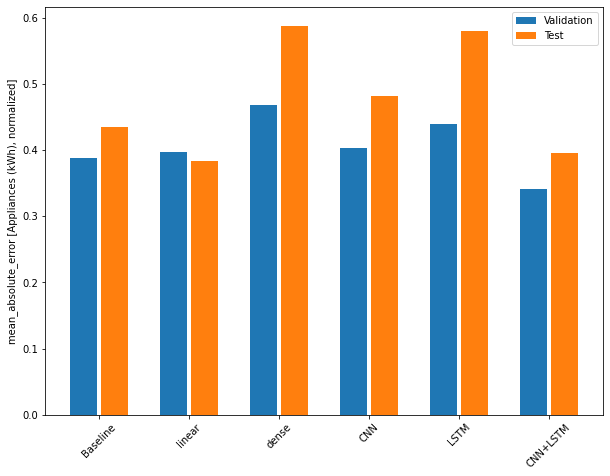

In [70]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Appliances (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [71]:
for name, value in performance.items():
    print(f'{name}: {value[1]:0.4f}')

Baseline: 0.4342
linear: 0.3841
dense: 0.5869
CNN: 0.4825
LSTM: 0.5798
CNN+LSTM: 0.3955


## Multi-Ouput Models 

In [72]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1
)

wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1
)

CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 27)
Labels shape (batch, time, features): (32, 24, 27)


### Baseline 

In [73]:
baseline = Baseline()
baseline.compile(loss=MeanSquaredError(),
                metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['baseline'] = baseline.evaluate(wide_window.val)
performance['baseline'] = baseline.evaluate(wide_window.test, verbose=0)

20/20 [==============================] - 0s 1ms/step - loss: 0.1296 - mean_absolute_error: 0.1775


### Dense 

In [74]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 3ms/step - loss: 0.6006 - mean_absolute_error: 0.5904 - val_loss: 0.5069 - val_mean_absolute_error: 0.5396
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.2719 - mean_absolute_error: 0.3731 - val_loss: 0.3347 - val_mean_absolute_error: 0.4285
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.2049 - mean_absolute_error: 0.3123 - val_loss: 0.2611 - val_mean_absolute_error: 0.3726
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1763 - mean_absolute_error: 0.2814 - val_loss: 0.2348 - val_mean_absolute_error: 0.3483
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1597 - mean_absolute_error: 0.2616 - val_loss: 0.2140 - val_mean_absolute_error: 0.3332
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1491 - mean_absolute_error: 0.2473 - val_loss: 0.1974 - val_mean_absolute_error: 0.3149
Epoch 7/50
72/72 [==========

### LSTM 

In [75]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 0.7100 - mean_absolute_error: 0.6557 - val_loss: 1.2691 - val_mean_absolute_error: 0.8211
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.3810 - mean_absolute_error: 0.4590 - val_loss: 0.8814 - val_mean_absolute_error: 0.6723
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2817 - mean_absolute_error: 0.3805 - val_loss: 0.7461 - val_mean_absolute_error: 0.6097
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2345 - mean_absolute_error: 0.3369 - val_loss: 0.6538 - val_mean_absolute_error: 0.5664
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2047 - mean_absolute_error: 0.3072 - val_loss: 0.5815 - val_mean_absolute_error: 0.5306
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1835 - mean_absolute_error: 0.2844 - val_loss: 0.5209 - val_mean_absolute_error: 0.5005
Epoch 7/50
72/72 [=========

### CNN + LSTM 

In [76]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8659 - mean_absolute_error: 0.7414 - val_loss: 1.9457 - val_mean_absolute_error: 1.1145
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8243 - mean_absolute_error: 0.7199 - val_loss: 1.9236 - val_mean_absolute_error: 1.1101
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8227 - mean_absolute_error: 0.7190 - val_loss: 1.9127 - val_mean_absolute_error: 1.1071
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8220 - mean_absolute_error: 0.7186 - val_loss: 1.9163 - val_mean_absolute_error: 1.1075
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8216 - mean_absolute_error: 0.7185 - val_loss: 1.9118 - val_mean_absolute_error: 1.1071
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8214 - mean_absolute_error: 0.7185 - val_loss: 1.9134 - val_mean_absolute_error: 1.1062
Epoch 7/50
72/72 [==========

### ResNet 

In [77]:
class ResidualWrapper(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        
        return inputs + delta

In [78]:
res_lstm = ResidualWrapper(
    Sequential([
        LSTM(32, return_sequences=True),
        Dense(
            num_features,
            kernel_initializer=tf.initializers.zeros    # Initialize predictions to 0
        )
    ])
)

history = compile_and_fit(res_lstm, wide_window)

val_performance['res_lstm'] = res_lstm.evaluate(wide_window.val)
performance['res_lstm'] = res_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1473 - mean_absolute_error: 0.1688 - val_loss: 0.1144 - val_mean_absolute_error: 0.1625
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 0.1298 - mean_absolute_error: 0.1580 - val_loss: 0.1055 - val_mean_absolute_error: 0.1637
Epoch 3/50
72/72 [==============================] - 0s 5ms/step - loss: 0.1119 - mean_absolute_error: 0.1547 - val_loss: 0.1034 - val_mean_absolute_error: 0.1649
Epoch 4/50
72/72 [==============================] - 0s 5ms/step - loss: 0.1024 - mean_absolute_error: 0.1525 - val_loss: 0.1040 - val_mean_absolute_error: 0.1675
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0974 - mean_absolute_error: 0.1508 - val_loss: 0.1057 - val_mean_absolute_error: 0.1699
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1076 - mean_absolute_error: 0.1712


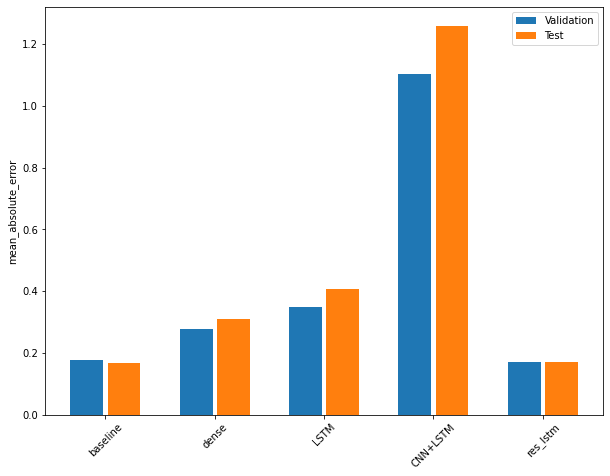

In [79]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [80]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

baseline    : 0.1658
dense       : 0.3102
LSTM        : 0.4069
CNN+LSTM    : 1.2574
res_lstm    : 0.1693


## Multi-Step Models 

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

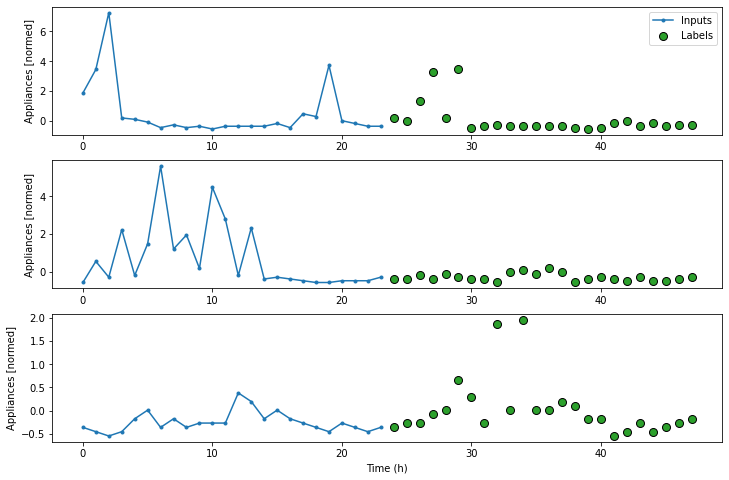

In [81]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=24,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline

In [82]:
class MultiStepLastBaseline(Model):
    def call(self, inputs):
        return tf.tile(inputs[:,-1:,:], [1, OUT_STEPS, 1])

In [83]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=MeanSquaredError(),
                     metrics=[MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 1ms/step - loss: 0.9511 - mean_absolute_error: 0.6514


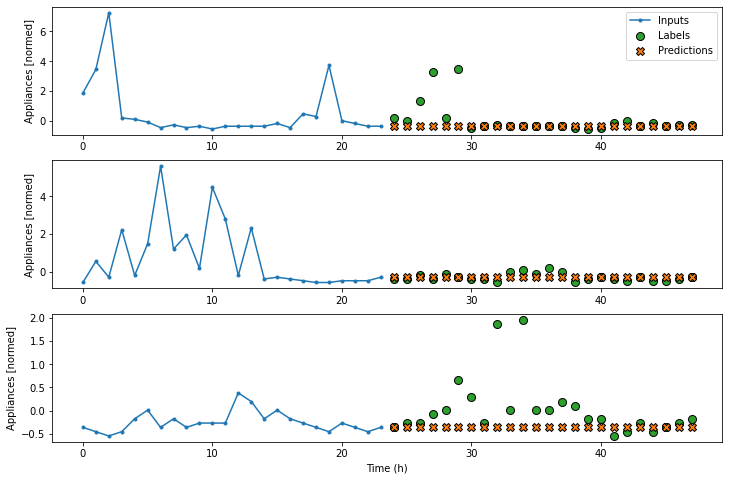

In [84]:
multi_window.plot(last_baseline)

In [85]:
class RepeatBaseline(Model):
    def call(self, inputs):
        return inputs

In [86]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=MeanSquaredError(),
                       metrics=[MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 2ms/step - loss: 0.5227 - mean_absolute_error: 0.4846


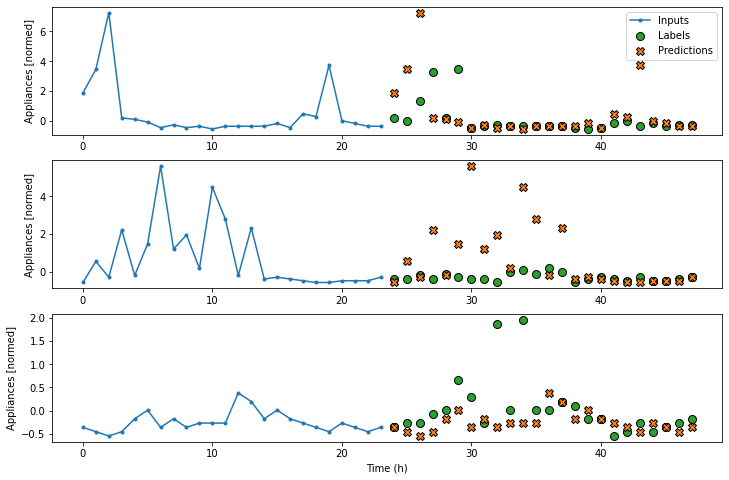

In [87]:
multi_window.plot(repeat_baseline)

### Linear - Single shot 

In [88]:
multi_linear_model = Sequential([
    # Take last time step
    Lambda(lambda x: x[:, -1:, :]),    # Shape [batch, time, features] => [batch, 1, features]
    Dense(OUT_STEPS*num_features,      # Shape [batch, 1, out_steps*features]
          kernel_initializer=tf.initializers.zeros),      
    Reshape([OUT_STEPS, num_features]) #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 2ms/step - loss: 0.6989 - mean_absolute_error: 0.6577 - val_loss: 0.9459 - val_mean_absolute_error: 0.7252
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.4675 - mean_absolute_error: 0.5171 - val_loss: 0.7288 - val_mean_absolute_error: 0.6114
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.4103 - mean_absolute_error: 0.4747 - val_loss: 0.6699 - val_mean_absolute_error: 0.5788
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3819 - mean_absolute_error: 0.4530 - val_loss: 0.6401 - val_mean_absolute_error: 0.5616
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3640 - mean_absolute_error: 0.4387 - val_loss: 0.6174 - val_mean_absolute_error: 0.5495
Epoch 6/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3514 - mean_absolute_error: 0.4283 - val_loss: 0.6015 - val_mean_absolute_error: 0.5399
Epoch 7/50
71/71 [==========

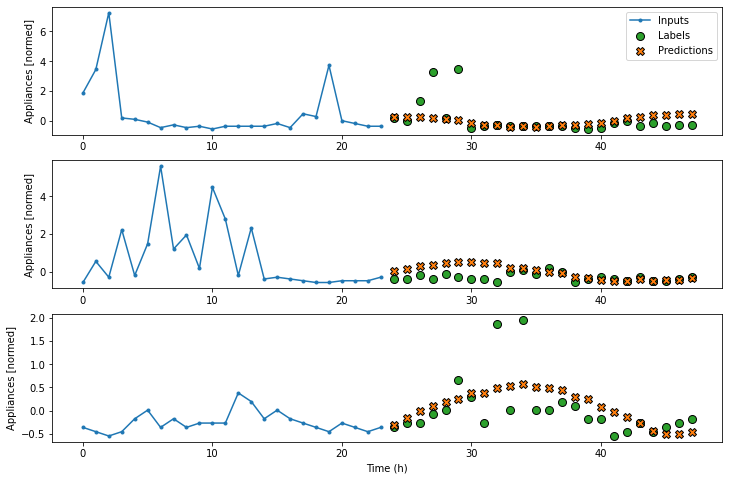

In [89]:
multi_window.plot(multi_linear_model)

### Dense - Single shot 

In [90]:
multi_dense_model = Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS*num_features, 
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 4ms/step - loss: 0.4652 - mean_absolute_error: 0.5018 - val_loss: 0.5955 - val_mean_absolute_error: 0.5334
Epoch 2/50
71/71 [==============================] - 0s 3ms/step - loss: 0.3012 - mean_absolute_error: 0.3786 - val_loss: 0.5719 - val_mean_absolute_error: 0.5177
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2797 - mean_absolute_error: 0.3577 - val_loss: 0.5655 - val_mean_absolute_error: 0.5106
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2656 - mean_absolute_error: 0.3446 - val_loss: 0.5853 - val_mean_absolute_error: 0.5169
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2552 - mean_absolute_error: 0.3354 - val_loss: 0.5898 - val_mean_absolute_error: 0.5185
Epoch 6/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5710 - mean_absolute_error: 0.5101


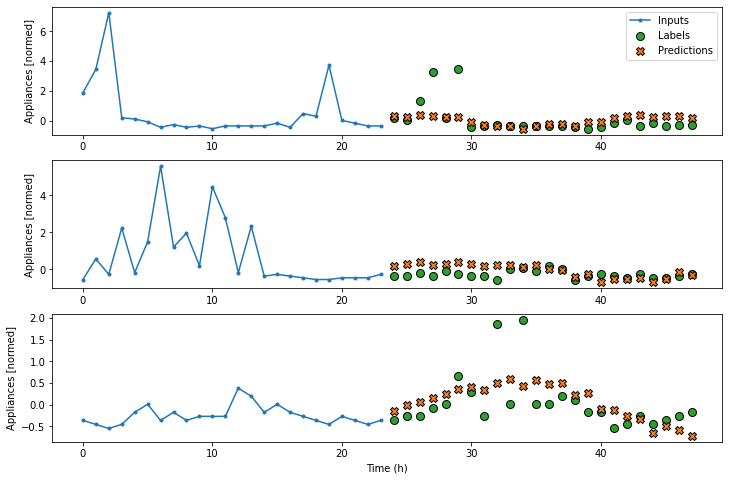

In [91]:
multi_window.plot(multi_dense_model)

### CNN - Single shot 

In [92]:
CONV_WIDTH = 3

multi_conv_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),         # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Conv1D(256, 
           activation='relu', 
           kernel_size=(CONV_WIDTH)),                # Shape [batch, 1, conv_units]
    Dense(OUT_STEPS*num_features, 
          kernel_initializer=tf.initializers.zeros), #Shape [batch, 1, out_step*features]
    Reshape([OUT_STEPS, num_features])               #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 4ms/step - loss: 0.4848 - mean_absolute_error: 0.5163 - val_loss: 0.6455 - val_mean_absolute_error: 0.5664
Epoch 2/50
71/71 [==============================] - 0s 3ms/step - loss: 0.3100 - mean_absolute_error: 0.3878 - val_loss: 0.5983 - val_mean_absolute_error: 0.5369
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2841 - mean_absolute_error: 0.3637 - val_loss: 0.5952 - val_mean_absolute_error: 0.5353
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2682 - mean_absolute_error: 0.3496 - val_loss: 0.6081 - val_mean_absolute_error: 0.5348
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2564 - mean_absolute_error: 0.3397 - val_loss: 0.5939 - val_mean_absolute_error: 0.5306
Epoch 6/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2479 - mean_absolute_error: 0.3325 - val_loss: 0.6132 - val_mean_absolute_error: 0.5352
Epoch 7/50
71/71 [==========

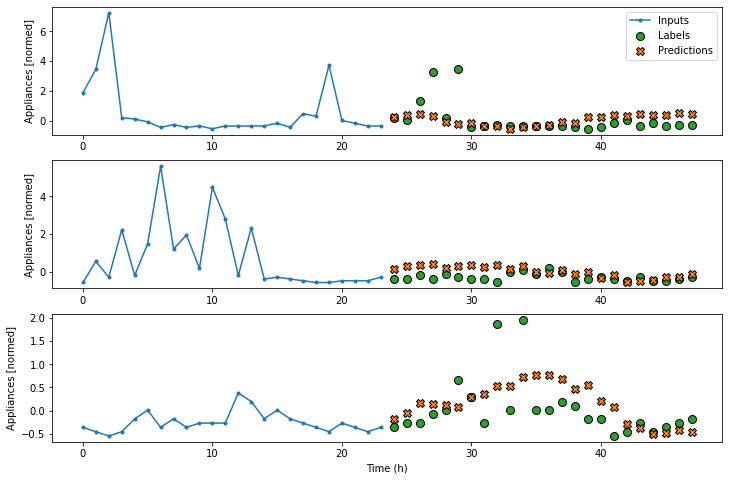

In [93]:
multi_window.plot(multi_conv_model)

### LSTM - Single shot 

In [94]:
multi_lstm_model = Sequential([
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 9ms/step - loss: 0.7699 - mean_absolute_error: 0.6919 - val_loss: 1.6336 - val_mean_absolute_error: 0.9693
Epoch 2/50
71/71 [==============================] - 0s 5ms/step - loss: 0.5389 - mean_absolute_error: 0.5588 - val_loss: 1.3795 - val_mean_absolute_error: 0.8729
Epoch 3/50
71/71 [==============================] - 0s 6ms/step - loss: 0.4572 - mean_absolute_error: 0.5069 - val_loss: 1.2473 - val_mean_absolute_error: 0.8211
Epoch 4/50
71/71 [==============================] - 0s 5ms/step - loss: 0.3697 - mean_absolute_error: 0.4435 - val_loss: 1.0653 - val_mean_absolute_error: 0.7543
Epoch 5/50
71/71 [==============================] - 0s 5ms/step - loss: 0.3265 - mean_absolute_error: 0.4072 - val_loss: 1.0327 - val_mean_absolute_error: 0.7424
Epoch 6/50
71/71 [==============================] - 0s 5ms/step - loss: 0.3075 - mean_absolute_error: 0.3914 - val_loss: 1.0253 - val_mean_absolute_error: 0.7401
Epoch 7/50
71/71 [==========

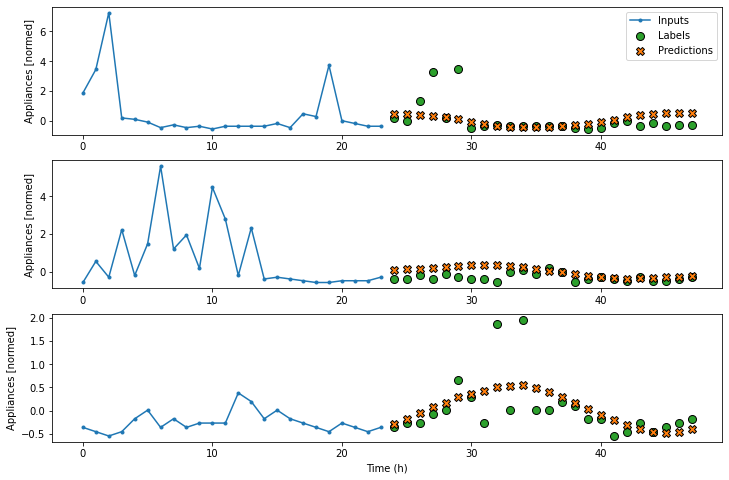

In [95]:
multi_window.plot(multi_lstm_model)

### CNN + LSTM - Single shot 

In [96]:
CONV_WIDTH = 3

multi_conv_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),         # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Conv1D(256, 
           activation='relu', 
           kernel_size=(CONV_WIDTH)),                # Shape [batch, 1, conv_units]
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features, 
          kernel_initializer=tf.initializers.zeros), #Shape [batch, 1, out_step*features]
    Reshape([OUT_STEPS, num_features])               #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['CNN+LSTM'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN+LSTM'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 9ms/step - loss: 0.8601 - mean_absolute_error: 0.7371 - val_loss: 1.6781 - val_mean_absolute_error: 0.9781
Epoch 2/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5772 - mean_absolute_error: 0.5782 - val_loss: 1.3414 - val_mean_absolute_error: 0.8681
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5055 - mean_absolute_error: 0.5350 - val_loss: 1.2502 - val_mean_absolute_error: 0.8395
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.4471 - mean_absolute_error: 0.4985 - val_loss: 1.1308 - val_mean_absolute_error: 0.7969
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.4089 - mean_absolute_error: 0.4714 - val_loss: 1.1015 - val_mean_absolute_error: 0.7829
Epoch 6/50
71/71 [==============================] - 0s 3ms/step - loss: 0.3716 - mean_absolute_error: 0.4448 - val_loss: 1.0455 - val_mean_absolute_error: 0.7542
Epoch 7/50
71/71 [==========

### LSTM - Autoregressive 

In [97]:
class FeedBack(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x,
                                     states=state,
                                     training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

Epoch 1/50
71/71 [==============================] - 1s 15ms/step - loss: 0.7691 - mean_absolute_error: 0.6844 - val_loss: 1.4923 - val_mean_absolute_error: 0.9039
Epoch 2/50
71/71 [==============================] - 1s 9ms/step - loss: 0.5430 - mean_absolute_error: 0.5597 - val_loss: 1.3858 - val_mean_absolute_error: 0.8808
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.4943 - mean_absolute_error: 0.5294 - val_loss: 1.3230 - val_mean_absolute_error: 0.8591
Epoch 4/50
71/71 [==============================] - 1s 8ms/step - loss: 0.4412 - mean_absolute_error: 0.4961 - val_loss: 1.2527 - val_mean_absolute_error: 0.8363
Epoch 5/50
71/71 [==============================] - 1s 8ms/step - loss: 0.3808 - mean_absolute_error: 0.4539 - val_loss: 1.1429 - val_mean_absolute_error: 0.7946
Epoch 6/50
71/71 [==============================] - 1s 8ms/step - loss: 0.3438 - mean_absolute_error: 0.4252 - val_loss: 1.1212 - val_mean_absolute_error: 0.7928
Epoch 7/50
71/71 [=========

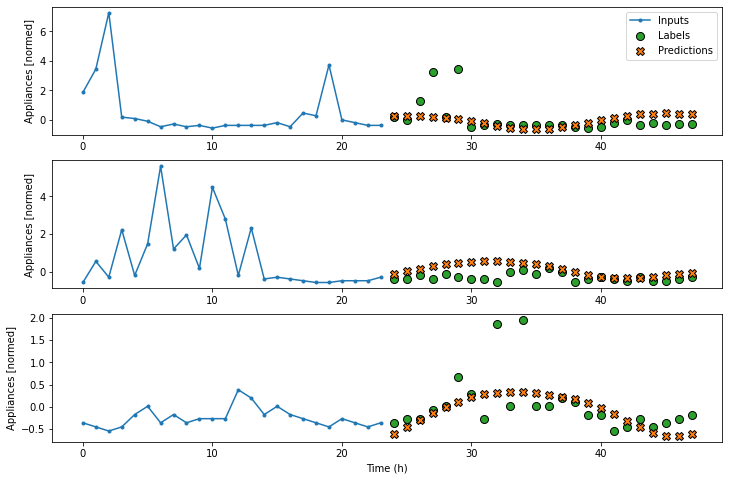

In [98]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

multi_window.plot(feedback_model)

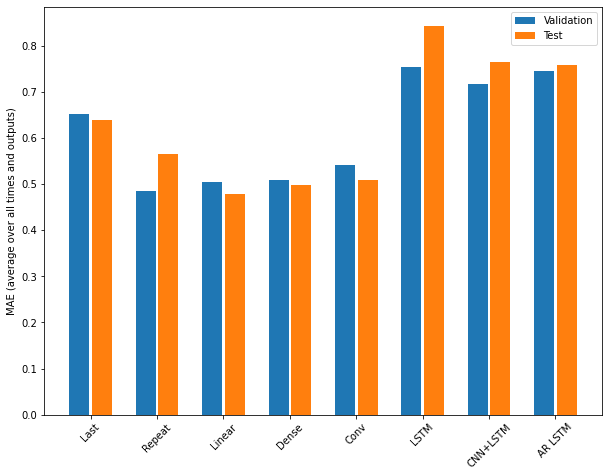

In [99]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend(loc='best')
plt.show()

In [100]:
for name, value in multi_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Last        : 0.6389
Repeat      : 0.5648
Linear      : 0.4785
Dense       : 0.4976
Conv        : 0.5099
LSTM        : 0.8422
CNN+LSTM    : 0.7656
AR LSTM     : 0.7590
